In [1]:
import pandas as pd
import numpy as np
import os
# import json
# import copy
from matplotlib import pyplot as plt
# from matplotlib_venn import venn2
# import path

from pathwayenrichment.representation import ClusterPermutator
from pathwayenrichment.databaseparser import KEGGPathwayParser 

from dokdonia import differentialexpression as DE
from dokdonia import visualization as VI
from dokdonia import clusteranalysis as CA
from dokdonia.utils import saveToPickleFile, readFromPickleFile, GenomeGBK

plt.style.use('plt_styles.mplstyle')
%matplotlib inline

# Load count data

In [2]:
# Loading counts and removing genes with low read counts across samples
min_count = 10

counts = pd.read_csv('data/DokdoniaCounts.csv', index_col=0)
counts = counts[counts.filter(regex='^[^T]+$').columns]
conditions = [name.split('.sam')[0] for name in counts.columns]
counts.columns = conditions
counts = counts[(counts > min_count).all(1)]
counts.reset_index(level=0, inplace=True)
counts.head()

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


,index,D_10_R1,D_10_R2,D_10_R3,D_18_R1,D_18_R2,D_18_R3,D_18_R4,D_25_R1,D_25_R2,...,L_18_R2,L_18_R3,L_18_R4,L_25_R1,L_25_R2,L_25_R3,L_34_R1,L_34_R2,L_34_R3,L_34_R4
0,MED134_07389,12973,11426,13251,30624,30618,41014,22449,53840,32369,...,16255,23945,20102,39444,41721,37020,39662,30983,27280,57834
1,MED134_07384,1557,1555,1552,4160,4385,5588,2940,7550,4509,...,2564,3003,2894,5419,5536,5318,5396,4751,4285,7818
2,MED134_07379,3400,3319,3273,7218,7903,9539,5040,13268,7572,...,4575,5361,4923,9089,9016,8529,10179,7617,7207,13827
3,MED134_07374,1987,2124,1404,3509,3772,4337,2602,4607,3316,...,1798,2558,2637,3586,3594,3488,4158,3096,2623,5323
4,MED134_07369,2087,2010,2111,3774,3809,4486,2901,4668,3456,...,2545,3456,3008,3705,4158,3760,5518,3563,2713,5150


# Find DE genes between Light and Dark

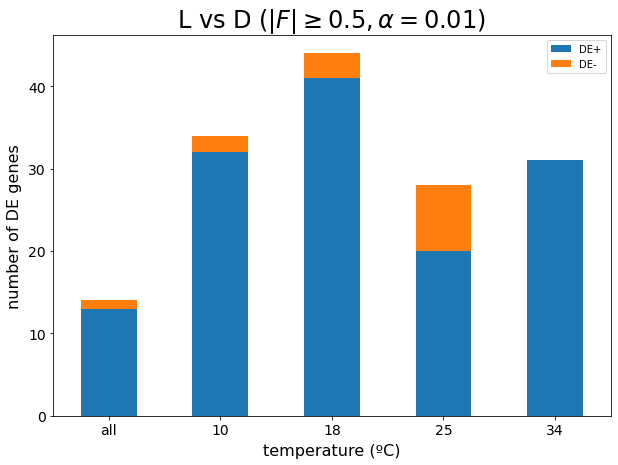

In [3]:
p_value_cutoff = 1e-2
fold_cutoff = k = 0.5

# DE light vs dark across temperatures
L_D_res, L_D_stats = {}, {}
L_D_res['all'], L_D_stats['all'] = DE.runDEtest(counts, test='Wald', alpha=p_value_cutoff,
                                                formula='~ lighting', log2fold_cutoff=k)
# L vs D for each temperature
for T in ['10', '18', '25', '34']:
    counts_T = counts[counts.filter(regex=f'{T}|index').columns]    
    L_D_res[T], L_D_stats[T] = DE.runDEtest(counts_T, test='Wald', alpha=p_value_cutoff,
                                            formula='~ lighting', log2fold_cutoff=k)
# Plot stats
ax = pd.DataFrame(L_D_stats).transpose().plot.bar(
    stacked=True, title=f'L vs D ($|F|\\geq 0.5,\\alpha={p_value_cutoff}$)',
    figsize=(10, 7), ylabel='number of DE genes', xlabel='temperature (ºC)',
    rot=0)

In [9]:
L_D_stats['18']

{'DE+': 41, 'DE-': 3}

We find DE genes, with a absolute fold cutoff value $|K|\geq0.5$ and significance level $\alpha=0.01$ across all temperatures. In all cases, there are more genes with greater expression under light than those with greater expression in the dark.

Let's look at the lists of DE genes across  temperatures:

In [4]:
# L > D, T = 18 Proteins [Sale alguno en cluster?]
gbk = GenomeGBK('data/DokdoniaMED134.gbk')
DELD = {}
for T, res in L_D_res.items():
    DELD[T] = {
        'L>D': {
            gene_id: gbk.getGeneInfo(gene_id)['product'][0]
            for gene_id in res[res.log2FoldChange >= k].index
        },
        'D>L': {
            gene_id: gbk.getGeneInfo(gene_id)['product'][0]
            for gene_id in res[res.log2FoldChange <= -k].index
        }
    }
DELD['18']

{'L>D': {'MED134_07319': 'hypothetical protein',
  'MED134_07209': 'hypothetical protein',
  'MED134_07119': 'rhodopsin',
  'MED134_07089': 'sensor of blue-light using FAD',
  'MED134_06804': 'two-component system response regulator',
  'MED134_06194': 'hypothetical protein',
  'MED134_06129': 'cold shock domain protein CspD',
  'MED134_05894': 'arginase family protein',
  'MED134_05889': 'Orn/DAP/Arg decarboxylase',
  'MED134_05499': 'hypothetical protein',
  'MED134_05339': 'hypothetical protein',
  'MED134_05334': 'GTP cyclohydrolase I',
  'MED134_04999': 'putative cell adhesion protein',
  'MED134_04254': 'hypothetical protein',
  'MED134_04249': 'hypothetical protein',
  'MED134_04009': 'ATP-dependent protease La (LON)',
  'MED134_03969': 'hypothetical protein',
  'MED134_03869': '50S ribosomal protein L31',
  'MED134_03409': 'hypothetical protein',
  'MED134_03404': 'ABC1 family protein',
  'MED134_15862': 'hypothetical protein',
  'MED134_02025': 'hypothetical protein',
  'MED13

# Effect of temperature on L-D DE genes
How do DE genes across light and dark behave across temperatures?

In [4]:
# Get light-dark DE genes at any temperature
k = 0.5
DE_all_T  = np.unique([g for g in L_D_res['all'][abs(L_D_res['all'].log2FoldChange) >= k].index]).tolist()
DE_plus = np.unique([g for L_D_res in L_D_res.values() for g in L_D_res[L_D_res.log2FoldChange >= k].index]).tolist()
DE_minus = np.unique([g for L_D_res in L_D_res.values() for g in L_D_res[L_D_res.log2FoldChange <= -k].index]).tolist()
DE_total = DE_plus + DE_minus
print(f'There are a total of {len(DE_total)} DE genes between Light and Dark')
print(f'There a total of {len(DE_all_T)} Light/Dark DE genes across the entire T range')

There are a total of 74 DE genes between Light and Dark
There a total of 14 Light/Dark DE genes across the entire T range


In [5]:
# Gettranscript/cell dataset
TC = pd.read_csv('data/Dokdonia_transcripts_cell.csv', index_col=0)
TC = TC[TC.filter(regex='^[^T]+$').columns] # remove technical replicates
TC = TC.dropna(axis=1) # Remove L_18_R4 and D_18_R4 which did no have internal standards
TC.iloc[:,1:] = 1e4 * TC.iloc[:,1:] # scale data to avoid numerical issues
TC = TC.set_index('index')
TC.index.name = 'ID'

# Effect of temperature on gene expression: Pathway enrichment analysis

Next, we analyze the effect that temperature may have on gene expression. To this end, we first cluster genes according to their across-temperature expression pattern, and then perform a permutation-based pathway enrichment analysis to evaluate which pathways are most affected by temperature changes.

To separate the effect of light and dark from that of temperature, we leave out of the analysis the set of genes that were DE between light and dark.

In [6]:
# Remove light-dark DE genes from dataset
TCnoDE = TC.loc[~TC.index.isin(DE_all_T)]

## Cluster by gene expression pattern

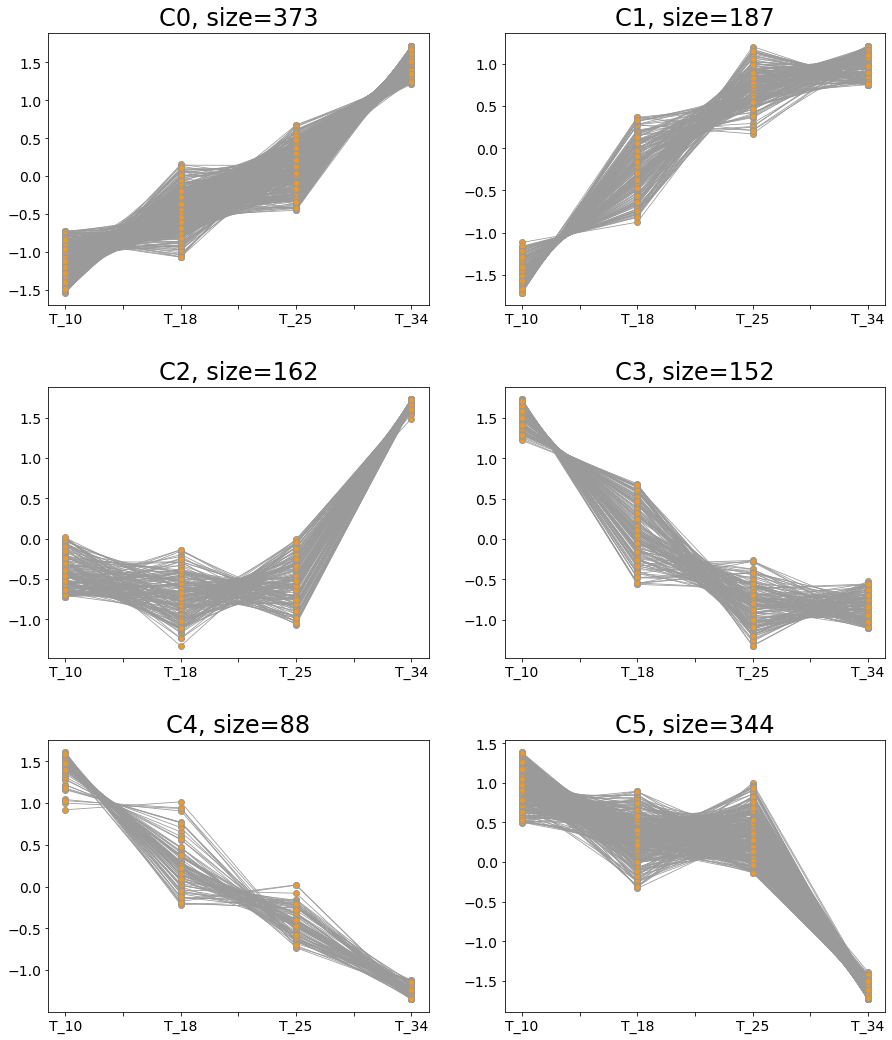

In [7]:
clust_tightness = 5
res_id = 'CLUSTER_ALL_GENES_TRANSCRIPT_CELL'
workdir = os.path.join(os.getcwd(),'results')

clusters = CA.getGeneClusters(TC, path_to_wd=workdir, 
                              out_dir=os.path.join(workdir, res_id),
                              cluster_tightness=clust_tightness,
                              normalization_file='clust_normalization.txt',
                              replicates_file='clust_replicates_merged_L_D.txt')

# Plot clusters
plot_cluster_data = pd.read_csv(os.path.join(
    os.getcwd(),f'results/{res_id}/Processed_Data/clust_input.tsv_processed.tsv'),
    sep='\t', index_col='Genes')
#plot_cluster_data.insert(4, '', [np.nan for n in range(plot_cluster_data.shape[0])])  # Add fake column to separate datasets

VI.plotClusters(plot_cluster_data, clusters)

In [81]:
TC.index[0]
[C for (C, V) in clusters.items() if TC.index[0] in V]

['C1']

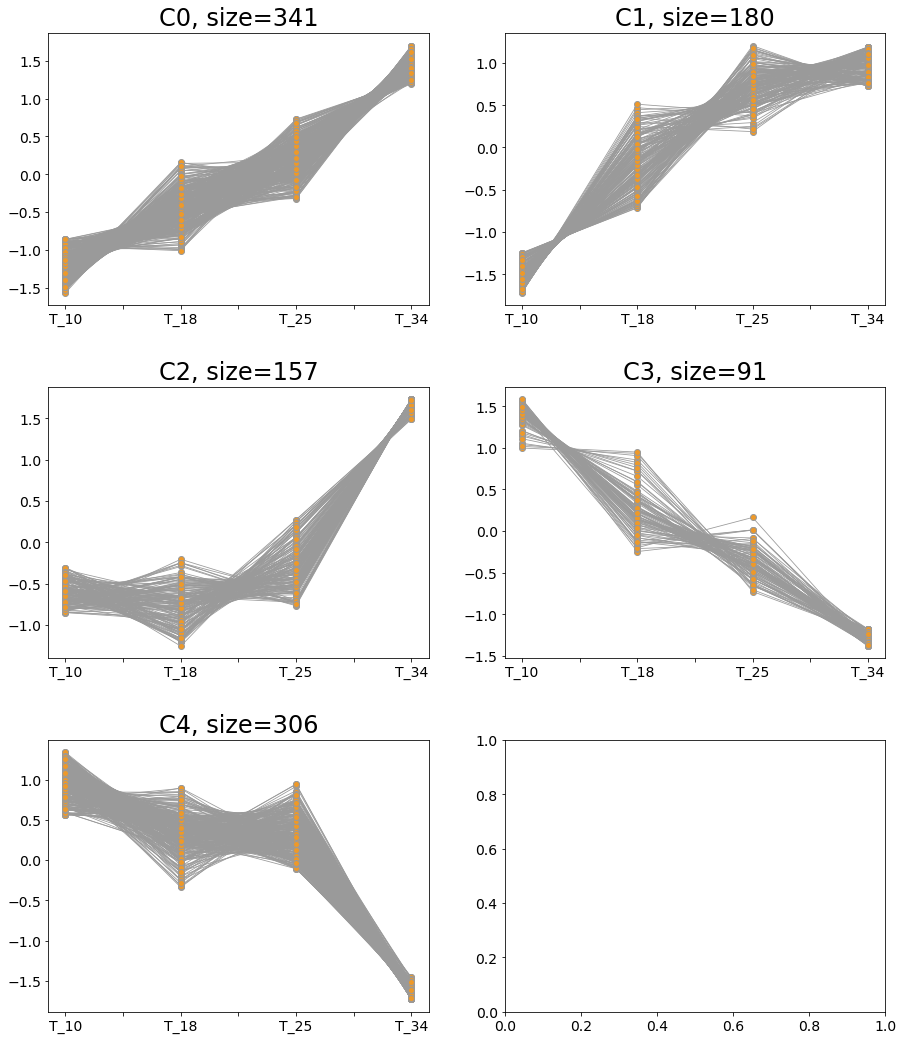

In [27]:
clust_tightness = 5
res_id = 'CLUSTER_NONDE_GENES_TRANSCRIPT_CELL'
workdir = os.path.join(os.getcwd(),'results')

clusters = CA.getGeneClusters(TCnoDE, path_to_wd=workdir, 
                              out_dir=os.path.join(workdir, res_id),
                              cluster_tightness=clust_tightness,
                              normalization_file='clust_normalization.txt',
                              replicates_file='clust_replicates_merged_L_D.txt')

# Plot clusters
plot_cluster_data = pd.read_csv(os.path.join(
    os.getcwd(),f'results/{res_id}/Processed_Data/clust_input.tsv_processed.tsv'),
    sep='\t', index_col='Genes')

VI.plotClusters(plot_cluster_data, clusters)

## Rank genes within clusters

Rank genes within clusters by ther silhouette

In [28]:
res_id = 'CLUSTER_NONDE_GENES_TRANSCRIPT_CELL'
cluster_data = pd.read_csv(os.path.join(
    os.getcwd(),f'results/{res_id}/Processed_Data/clust_input.tsv_processed.tsv'),
    sep='\t', index_col='Genes')
ranked_clusters = CA.rankGenesWithinClusters(clusters, cluster_data)

## Pathway enrichment analysis

In [8]:
# Parse KEGG Dokdonia's orthology
KEGGparser = KEGGPathwayParser.fromKEGGidentifier('dok', only_curated_pathways=True)
gene_pathways, gene_systems = KEGGparser.getGenePathways()
system_pathways = KEGGparser.getSystemPathways()
gene_info = KEGGparser.getGeneInfoFromKEGGorthology()

# Run analysis
permutator = ClusterPermutator(clusters, gene_pathways, system_pathways)

In [10]:
pathway_res = permutator.sampleClusterPermutationSpace(sample_size=200000, n_processes=8)
saveToPickleFile(pathway_res, 'results/enrichment_result_all_genes.pkl')

In [35]:
pathway_res['pathway']['C4']

{'03010 Ribosome [PATH:dok03010]': (0.5161290322580645, 0.0),
 '00970 Aminoacyl-tRNA biosynthesis [PATH:dok00970]': (0.140625, 0.00546),
 '00380 Tryptophan metabolism [PATH:dok00380]': (0.3157894736842105, 0.008185),
 '00740 Riboflavin metabolism [PATH:dok00740]': (0.5, 0.02303),
 '00770 Pantothenate and CoA biosynthesis [PATH:dok00770]': (0.2222222222222222,
  0.02433),
 '00340 Histidine metabolism [PATH:dok00340]': (0.26666666666666666, 0.02516),
 '03440 Homologous recombination [PATH:dok03440]': (0.22727272727272727,
  0.08003),
 '00410 beta-Alanine metabolism [PATH:dok00410]': (0.5, 0.080245),
 '00053 Ascorbate and aldarate metabolism [PATH:dok00053]': (0.4, 0.080925),
 '03020 RNA polymerase [PATH:dok03020]': (0.6666666666666666, 0.08122),
 '00230 Purine metabolism [PATH:dok00230]': (0.16216216216216217, 0.18227),
 '00072 Synthesis and degradation of ketone bodies [PATH:dok00072]': (0.5,
  0.19691),
 '00730 Thiamine metabolism [PATH:dok00730]': (0.25, 0.19696),
 '00130 Ubiquinone a

## Visualization

In [ ]:
pathway_res = readFromPickleFile('results/enrichment_result_all_genes.pkl')
cluster_colors =     {
        'C0': '#3d03fc', 'C1': '#036bfc', 'C2': '#03adfc',
        'C3': '#fc4e03', 'C4': '#fc0303', 'C5': '#fc7703', 
        'C6': '#03fc7b', 'No cluster': 'white'
    }

VI.plotSystemsAndSubsystemsStacked(pathway_res, cluster_colors, 'iplots_Stacked')